In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import optimize
from PIL import Image
%matplotlib inline


Возьмем для оптимизации тестовую функцию Леви №13

$f(x,y) = \sin^3(2\pi x)+(x-1)^2(1+sin^2(3 \pi y))+(y-1)^2(1-sin^2(2 \pi y))$

$f_{min}=f(1,1)=0$

$-10\leq x,y\leq 10$

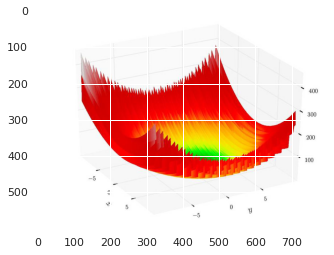

In [2]:
plt.imshow(np.array(Image.open('../data/shrek.jpeg')))

Используем для оптимизации алгоритм сопряженных градиентов.

Алгоритм сопряженных градиентов Ньютона является модифицированным методом Ньютона.
Метод Ньютона основан на аппроксимации функции в локальной области полиномом второй степени:

$f(x)\approx f(x_0)+\Delta{f(x_0)}\cdot (x-x_0)+\frac{1}{2}(x-x_0)^T H(x_0)(x-x_0)$

где $H(x_0)$ является матрицей вторых производных (матрица Гессе)
Если гессиан положительно определен, то локальный минимум этой функции можно найти, приравняв нулевой градиент квадратичной формы к нулю.
В результате получится выражение:

$x_{opt}=x_0-H^{-1}\Delta f$

Для ускорения рассчетов применим пакет numba, скомпилируем функцию как c функцию для передачи как аргумент в функции вычисления градиента и гессиана.

In [3]:
@nb.cfunc("float64(float64[:])")
def f(x):
    return np.sin(3*np.pi*x[0])**2+((x[0]-1)**2)*(1+np.sin(3*np.pi*x[1])**2)+((x[1]-1)**2)*(1+np.sin(2*np.pi*x[1]**2))

Будем вычислять частные первые и вторые производные для градиента и гессиана численно.
Так как в реальных задачах аналитически их найти или невозможно или крайне затратно.

$\frac{\delta f(x_1,\dots,x_n)}{\delta x_k} = \frac{f(\dots,x_k+\Delta x,\dots)-f(\dots,x_k-\Delta x,\dots)}{2 \Delta x}$

Аналогично будем искать вторые частные проивзодные

$\frac{\delta^2 f(x_1,\dots,x_n)}{\delta x_k \delta x_m}=\frac{\frac{f(\dots,x_k+\Delta x,\dots)}{\delta x_m}-\frac{f(\dots,x_k-\Delta x,\dots)}{\delta x_m}}{2 \Delta x_k} =...$

Реализация позволяет искать градиент и гессиан n-мерной функции

In [4]:
@nb.njit
def diff(f,p,n,h=0.01):
    p[n]=p[n]+h
    f1 = f(p)
    p[n]=p[n]-2*h
    f2 = f(p)
    p[n]=p[n]+h
    # f3= f(p)

    return (f1-f2)/(2*h)
@nb.njit
def diff2(f:callable,p,n1,n2,h=0.01):
    p[n1]=p[n1]+h
    p[n2]=p[n2]+h
    f1 = f(p)
    p[n2]=p[n2]-2*h
    f3 = f(p)
    p[n1]=p[n1]-2*h
    # p[n2]=p[n1]-2*h
    f4= f(p)
    p[n2]=p[n2]+2*h
    f2=f(p)
    p[n1]=p[n1]+h
    p[n2]=p[n2]-h

    return (f1-f2-f3+f4)/(4*h**2)
@nb.njit
def grad(f:callable,p,h=0.01):
    df = np.empty_like(p)
    for i in range(df.shape[0]):
        df[i]= diff(f,p,i,h)
    return df
@nb.njit()
def hess(f:callable,p,h=0.01):
    ddf = np.empty((p.shape[0],p.shape[0]),dtype=np.float32)
    for i in range(p.shape[0]):
        for j in range(i,p.shape[0]):
            ddf[i,j]=diff2(f,p,i,j,h)
    for i in range(p.shape[0]):
        for j in range(i):
            ddf[i,j]=ddf[j,i]
    return ddf

Используем встроенную функцию для оптимизации методом сопряженный градиентов.

Алгоритм не очень успешно справился с поиском минимума, так как тестовая функция имеет очень большое количество локальных минимумов ( что имитирует реальные зашумленные данные), что в свою очередь мешаем методам, основанным на градиенте и/или гессиане/

Полученные значения = [1.32,-1.93], истинный минимум = [1,1]

In [5]:
@nb.njit
def fgrad(p):
    return grad(f,p)
@nb.njit
def fhess(p):
    return hess(f,p)
# p = 20*np.random.random(2)-10
# кАк БуДтО бЫ сЛуЧаЙнО
p = np.array([6,-2],dtype=np.float64)
res=optimize.minimize(f, p, method='Newton-CG', jac=fgrad,hess=fhess, options={'disp': False,'return_all':True})
res

 allvecs: [array([ 6., -2.]), array([ 5.99790376, -1.95182266]), array([ 5.99637346, -1.96592039]), array([ 5.93773441, -1.96501468]), array([ 5.90515095, -1.96477532]), array([ 1.33765014, -1.9981308 ]), array([ 1.33734184, -1.94904618]), array([ 1.33703651, -1.9363749 ]), array([ 1.32836914, -1.93661977]), array([ 1.32838804, -1.93661907])]
     fun: 0.14416621112437608
     jac: array([-0.01091405, -0.01186181])
 message: 'Optimization terminated successfully.'
    nfev: 26
    nhev: 9
     nit: 9
    njev: 25
  status: 0
 success: True
       x: array([ 1.32838804, -1.93661907])

Вспомогательная функция для получения значения функции из входных данных в форме сетки, для дальнейшей отрисовки

In [6]:
@nb.njit
def mesh_dec(f,x,y):
    z = np.empty_like(x)
    arg = np.empty(2,dtype=np.float64)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            arg[0]=x[i,j]
            arg[1]=y[i,j]
            z[i,j]=f(arg)
    return z

Отрисовка функции и шагов поиска.
Зеленые линии - шаги оптимизации
1 график - график поверхности, 2 график - график линий уровня (черная точка - глобальный минимум)

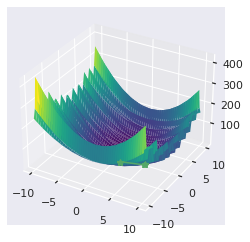

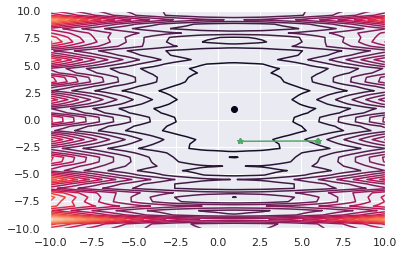

In [7]:
x, y = np.mgrid[-10:10:50j,
                -10:10:50j]
z = mesh_dec(f,x,y)


fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x,y, z,
                cmap='viridis',edgecolor='none')
ax.plot3D([i[0] for i in res.allvecs],[i[1] for i in res.allvecs],[f(i) for i in res.allvecs], '-*g')
plt.show()


plt.contour(x,y,z,levels=20)
plt.plot([i[0] for i in res.allvecs],[i[1] for i in res.allvecs],'-*g')
# plt.scatter([3,-2.805,-3.77,3.58],[2,3.13,-3.28,-1.84],c=[20,20,20,20])
plt.scatter([1],[1],c=[40])
plt.show()

Решить проблему застревания в локальных минимумах может моментных адаптивный алгоритм стохастической оптимизации Adam,
который является одним из самых эффективным на сегодня.

Adam — adaptive moment estimation. Он сочетает в себе и идею накопления движения и идею более слабого обновления весов для типичных признаков.

Происходит адаптивное накопление градиента

$m_t=\beta_1 m_{t-1}+(1-\beta_1)g_t $

Также оценивается средняя нецентрированная дисперсия

$v_t=\beta_2 u_{t-1}+(1-\beta_2)g^2_t$

Расчет моментов:

$ \hat{m}_t =\frac{m_t}{1-\beta^t_1}, \hat{v}_t=\frac{v_t}{1-\beta^t_2}$

В итоге правило обновления:
$\theta_{t+1}=\theta_t-\frac{\eta}{\sqrt{\hat{v_t}+\epsilon}} \hat{m_t}$

$\eta$ - learning rate скорость обновления

Авторы Adam предлагают в качестве значений по умолчанию

$\beta_1=0.9, \beta_2=0.999, \epsilon=10^{-8}$

Алгоритм написан таким образом, что останавливается либо при очень малом увеличении параметра $\theta$, либо после истечения 10000 итераций.
Скорость работы увеличена с помощью пакета numba.
Алгоритм возвращает все шаги оптимизации (для отрисовки).

[(126, 2), array([1.00069008, 0.99833436])]


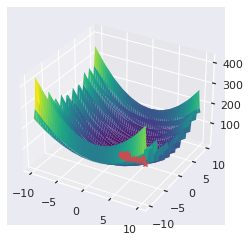

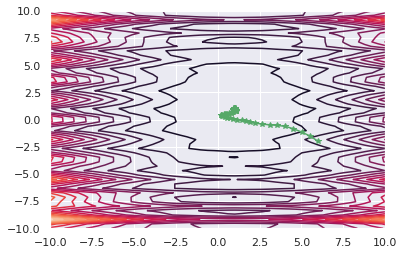

In [8]:
@nb.njit
def adam(grad,p0, beta1=0.9, beta2=0.999, lr=0.25, eps=0.0000001):
    # tet0=p0
    tet=p0.copy()
    # Y = []
    m = np.zeros_like(p0)
    v = np.zeros_like(p0)
    eps_range=0.0001
    all_tet = np.empty((100,2),dtype=np.float64)
    all_tet[0,:]=tet
    i =0
    while i<10000:
        # pass
        grad_val = -grad(tet)

        m = beta1*m + (1-beta1)*grad_val
        v = beta2*v + (1-beta2)*grad_val*grad_val
        m_hat = m/(1- np.power(beta1, i+1) )
        v_hat = v/(1- np.power(beta2, i+1) )
        dthetha = lr/np.sqrt(v_hat + eps)*m_hat
        tet=tet+dthetha

        if all_tet.shape[0]<=i+1:
            buf=all_tet.copy()
            all_tet = np.empty((all_tet.shape[0]+100,all_tet.shape[1]),dtype=all_tet.dtype)
            all_tet[:buf.shape[0],:] = buf
        all_tet[i+1,:]=tet
        if np.linalg.norm(dthetha)<eps_range:
            break
        i+=1

    # return tet
    return all_tet[:i+1,:].copy()
res2=adam(fgrad,p,0.9,0.999,0.5)
print([res2.shape,res2[-1,:]])



fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x,y,z,
                cmap='viridis',edgecolor='none')

ax.plot3D(res2[:,0],res2[:,1],[f(i) for i in res2], '-*r',linewidth=2)
plt.show()
# ax.plot3D([i[0] for i in res.allvecs],[i[1] for i in res.allvecs],[f(i) for i in res.allvecs], 'gray')
plt.contour(x,y,z,levels=20)
plt.plot(res2[:,0],res2[:,1],'-*g')
# plt.scatter([3,-2.805,-3.77,3.58],[2,3.13,-3.28,-1.84],c=[20,20,20,20])
plt.show()


Результат работы алгоритма:

$\hat{f}_{min}=f(1.00006,0.99833)=4.54e^{-05}$

Что совпадает с глоабльным минимумом в рамках погрешности.

Генетический алгоритм дял решения задачи оптимизации.

Генетический алгоритм-это эвристический алгоритм поиска, используемый для решения задач оптимизации и моделирования путём случайного подбора, комбинирования и вариации искомых параметров с использованием механизмов, аналогичных естественному отбору в природе

Кодируем проблему поиска с помощью класса levi13_problem, который использует функцию леви 13, описанную выше.

In [9]:
import pygmo as pg

class levi13_problem:
    def __init__(self):
        self.dim = 2
    def fitness(self,x):
        return np.array([f(x)])
    def get_bounds(self):
        return np.full((self.dim,),-10.),np.full((self.dim,),10.)

Используем алгоритм пчелиной колонии для решения задачи.

Алгоритм пчелиной колонии (алгоритм оптимизации подражанием пчелиной колонии, англ. artificial bee colony optimization, ABC) — один из полиномиальных эвристических алгоритмов для решения оптимизационных задач в области информатики и исследования операций, основан на имитации поведения колонии медоносных пчел при сборе нектара в природе.

Создадим популяцию пчел, проблему и сам алгоритм. Произведем вычисления

In [10]:
# algo = pg.algorithm(pg.sga(gen = 500))
# algo.set_verbosity(50)
algo = pg.algorithm(pg.bee_colony(gen = 20, limit = 20))
prob = pg.problem(levi13_problem())
pop = pg.population(prob,200)

pop = algo.evolve(pop)


[pop.champion_x,pop.champion_f]

[array([1.00077883, 0.99350647]), array([9.32284663e-05])]

Результат работы алгоритма сошелся в точку глобального минимума, что говорит о его высокой эффективности